In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vespainv.model import VespaModel, Prior
from vespainv.waveformBuilder import create_U_from_model

In [5]:
# --- Time and STF setup ---
dt = 0.01
time = np.arange(-10, 30, dt)
stf_time = np.arange(-1, 1, dt)
stf = np.exp(-((stf_time / 0.2)**2))  # Gaussian STF

In [6]:
# --- Synthetic model setup ---
# model = VespaModel.create_empty(Nphase=1, Ntrace=5)
# model.arr[0] = 10.0      # arrival at 10s
# model.slw[0] = 0.05      # s/deg
# model.amp[0] = 1.0       # unit amplitude
# model.distDiff[0] = 0.0
# model.bazDiff[0] = 0.0

In [7]:
# --- Station metadata with small perturbations ---
np.random.seed(0)
base_dist = 35.0
base_baz = 70.0
Ntrace = 10
dists = base_dist + np.random.uniform(-0.0, 0.0, Ntrace)
bazs = base_baz + np.random.uniform(-10.0, 10.0, Ntrace)
station_metadata = np.column_stack((dists, bazs))

# --- Prior ---
prior = Prior(refLat = 0., refLon = 0.,refBaz=base_baz, timeRange=(time[0],time[-1]))

In [15]:
model = VespaModel.create_random(Nphase=3, Ntrace=Ntrace, time=time, prior=prior)
print(model)

VespaModel(Nphase=3, Ntrace=10, arr=array([27.74048566, 17.26599376,  4.37672094]), slw=array([-0.02518722,  0.07905248, -0.17590981]), amp=array([ 0.33353343,  0.34127574, -0.57923488]), distDiff=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), bazDiff=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


In [16]:
# --- Generate synthetic seismograms ---
U = create_U_from_model(model, prior, station_metadata, time, stf_time, stf)


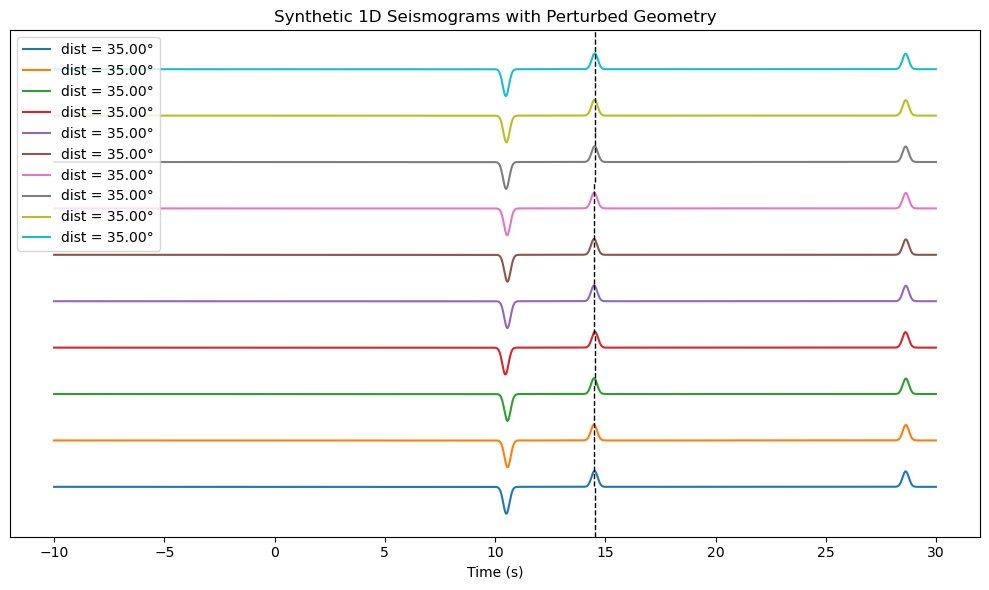

In [17]:
# --- Plot ---
plt.figure(figsize=(10, 6))
for i in range(U.shape[0]):
    trace = U[i]
    plt.plot(time, trace + i, label=f'dist = {dists[i]:.2f}°')

    # Find peak time
    peak_idx = np.argmax(trace)
    peak_time = time[peak_idx]
    plt.axvline(x=peak_time, ymin=i / U.shape[0], ymax=(i + 1) / U.shape[0],
                color='k', linestyle='--', linewidth=1)

plt.xlabel("Time (s)")
plt.title("Synthetic 1D Seismograms with Perturbed Geometry")
plt.yticks([])
plt.legend()
plt.tight_layout()
# plt.xlim(5, 15)
plt.show()


In [11]:
from vespainv.utils import dest_point

lat1 = 4.5
lon1 = 135.9
baz = 77
dist = 28.7

lat2, lon2 = dest_point(lat1, lon1, baz, dist)
print(lat2, lon2)

10.16676782304183 164.28407774089493


VespaModel3c(Nphase=3, Ntrace=50, arr=array([30, 60, 90], dtype=int32), slw=array([0.02454388, 0.08035901, 0.01963813]), amp=array([0.8287552 , 0.70370466, 0.91950144]), dip=array([36.93019552, 79.27927648, 77.15441276]), azi=array([121.49896421,  13.30787306,  18.47498263]), ph_hh=array([ 19.644717  ,   9.16823693, -86.64641769]), ph_vh=array([-14.04101018, -69.63250878,  80.29103658]), atts=array([3.16267135, 0.98050581, 2.80151043]), svfac=array([0.75064144, 0.59597878, 0.63114388]), wvtype=array([1, 1, 0], dtype=int32), distDiff=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), bazDiff=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


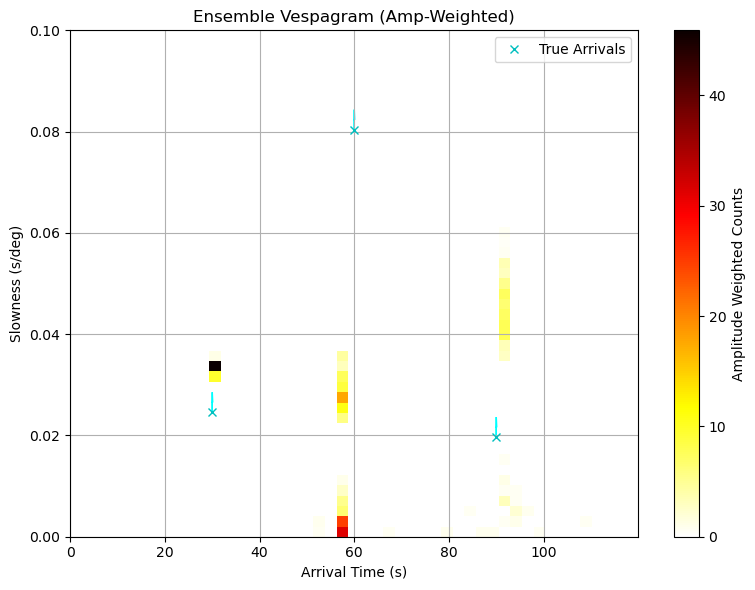

In [1]:
from vespainv.visualization import plot_ensemble_vespagram
import pickle, os
import numpy as np

synDir = "./synData/model3/"
resDir = "./runs/syn/model3/run2.1_T=0.1_freq/"

with open(os.path.join(resDir, "ensemble.pkl"), "rb") as f:
    ensemble = pickle.load(f)
with open(os.path.join(synDir, "synPrior.pkl"), "rb") as f:
    prior = pickle.load(f)
with open(os.path.join(synDir, "synModel.pkl"), "rb") as f:
    model = pickle.load(f)
Utime  = np.loadtxt(os.path.join(synDir, "time_syn.csv"), delimiter=",")  # columns: time

plot_ensemble_vespagram(ensemble, Utime, prior, amp_weighted=True, true_model=model)
print(model)

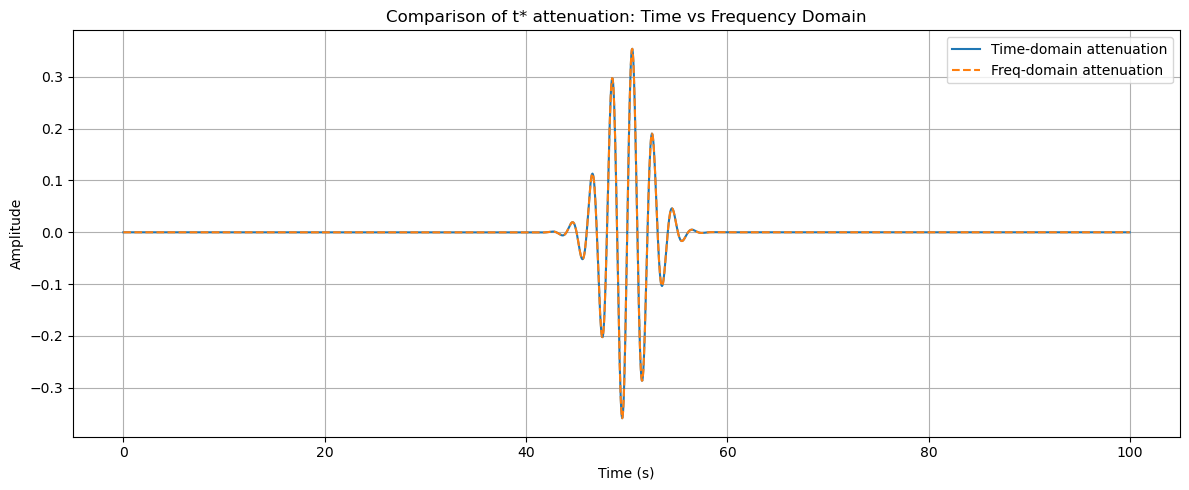

In [30]:
import numpy as np
from vespainv.waveformBuilder import tstar_conv

def tstar_conv_freqdomain(W: np.ndarray, freqs: np.ndarray, t_star: float) -> np.ndarray:
    """
    Apply t* attenuation in the frequency domain.

    Parameters:
    - W: Fourier-transformed waveform (1D complex array)
    - freqs: frequency array corresponding to W
    - t_star: t* value

    Returns:
    - W_attenuated: Attenuated waveform in frequency domain
    """
    f = freqs * t_star
    f0 = 1.0 * t_star  # reference frequency
    f_f0 = f / f0

    # Create attenuation operator
    attenuation = np.exp(-np.pi * f) * np.power(
        f_f0, 1j * 2 * f, where=f_f0 > 0, out=np.zeros_like(f_f0, dtype=complex)
    )
    W_attenuated = W * attenuation
    W_attenuated[0] = 0  # Zero the DC component

    return W_attenuated

# === Cross check ===
import matplotlib.pyplot as plt

# Create test waveform
dt = 0.05
N = 2000
time = np.arange(N) * dt
f0 = 0.5  # dominant frequency
wvfm = np.sin(2 * np.pi * f0 * time) * np.exp(-((time - 50)**2) / 10)

# FFT of original waveform
W = np.fft.fft(wvfm)
freqs = np.fft.fftfreq(N, dt)

# Apply both methods
t_star = 0.2
wvfm_att_time = tstar_conv(wvfm, time, t_star)
W_att = tstar_conv_freqdomain(W, freqs, t_star)
wvfm_att_freq = np.fft.ifft(W_att).real

# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(time, wvfm_att_time, label="Time-domain attenuation")
plt.plot(time, wvfm_att_freq, label="Freq-domain attenuation", linestyle='--')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Comparison of t* attenuation: Time vs Frequency Domain")
plt.grid(True)
plt.tight_layout()
plt.show()


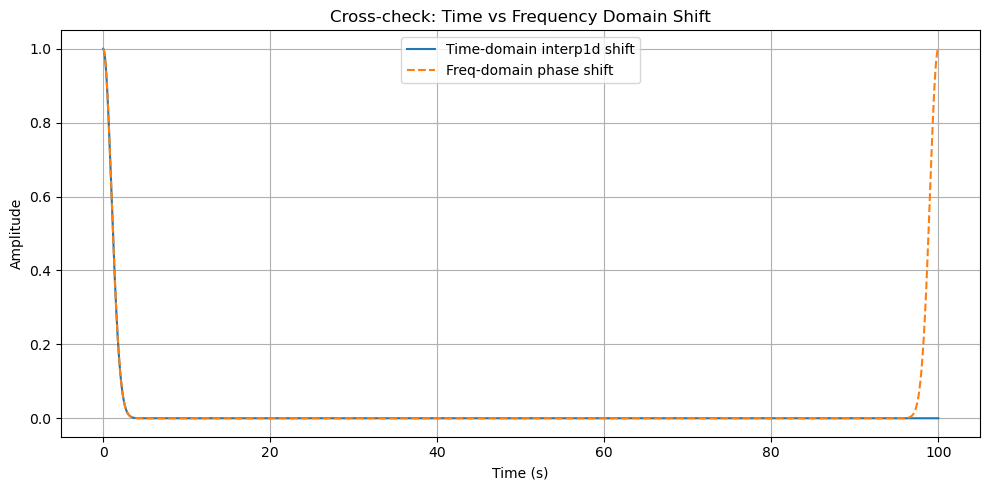

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftfreq

# Parameters
dt = 0.01
N = 1000          # Length of original waveform
Nlong = 10000     # Length of target waveform (longer to hold shift)
time = np.arange(N) * dt  # Original time vector
timelong = np.arange(Nlong) * dt  # Target time vector
freq_long = fftfreq(Nlong, dt)

tshift = -5  # seconds

# Generate test waveform (Gaussian pulse)
center = 5.0
width = 1.0
P_wvlt = np.exp(-((time - center) ** 2) / (2 * width ** 2))

# ----------------------------
# TIME-DOMAIN INTERPOLATION SHIFT
# ----------------------------
# Interpolate with shifted time vector and evaluate at timelong
P_shifted_time = interp1d(
    time + tshift,
    P_wvlt,
    kind='linear',
    bounds_error=False,
    fill_value=0.0
)(timelong)

# ----------------------------
# FREQUENCY-DOMAIN PHASE SHIFT
# ----------------------------
# Zero-pad P_wvlt to match Nlong
P_wvlt_padded = np.pad(P_wvlt, (0, Nlong - N))

# FFT of the zero-padded waveform
P_wvlt_W = fft(P_wvlt_padded)

# Apply phase shift in frequency domain
phase_shift = np.exp(-2j * np.pi * freq_long * tshift)
P_wvlt_W_shifted = P_wvlt_W * phase_shift

# IFFT to get back the time-domain waveform
P_shifted_freq = np.real(ifft(P_wvlt_W_shifted))

# ----------------------------
# PLOT FOR CROSS-CHECK
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(timelong, P_shifted_time, label='Time-domain interp1d shift')
plt.plot(timelong, P_shifted_freq, '--', label='Freq-domain phase shift')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Cross-check: Time vs Frequency Domain Shift")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
from vespainv.utils import prepare__inputs_from_sac
data_dir = "/Users/evanzhang/Documents/Research/fetchData/event_download/200705062111/"
output_dir = "/Users/evanzhang/Documents/Research/VespaPolPy/RealData/200705062111/"
prepare__inputs_from_sac(data_dir, output_dir)

Saved data to: /Users/evanzhang/Documents/Research/VespaPolPy/RealData/200705062111/


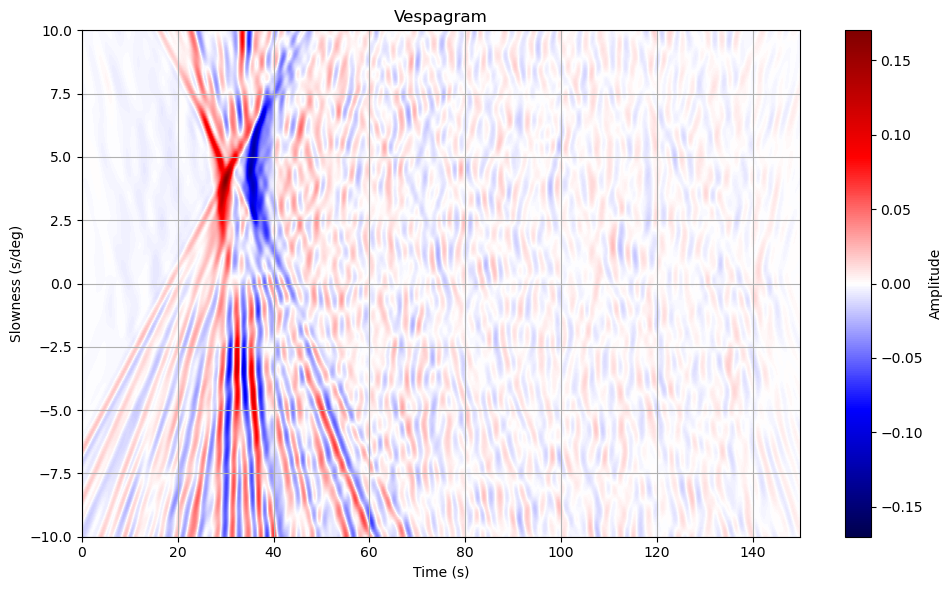

array([[-0.0152925 , -0.0152809 , -0.01525795, ...,  0.00378579,
         0.00383692,  0.00388085],
       [-0.01501391, -0.01513725, -0.01524146, ...,  0.00435254,
         0.00432615,  0.00429254],
       [-0.01318492, -0.01351451, -0.01381869, ...,  0.00427722,
         0.00417945,  0.00407704],
       ...,
       [-0.00074287, -0.00079014, -0.00083738, ..., -0.0040114 ,
        -0.00404433, -0.00406625],
       [-0.00092634, -0.00096909, -0.00101174, ..., -0.00407124,
        -0.00415662, -0.00423137],
       [-0.00107366, -0.00111306, -0.0011524 , ..., -0.00377566,
        -0.00391631, -0.00404796]])

In [7]:
from vespainv.utils import make_vespagram, dest_point, bandpass
import numpy as np
import os, pickle

isSyn = False
evname = "200705062111"
Uname = "UZ.csv"
slow_grid = np.linspace(-10,10,201)
isbp = True
freqs = np.array([0.02, 0.5])

if isSyn:
    datadir = "./SynData/"
else:
    datadir = "./RealData/"

U_obs = np.loadtxt(os.path.join(datadir, evname, Uname), delimiter=",")  # columns: data
Utime = np.loadtxt(os.path.join(datadir, evname, "time.csv"), delimiter=",")  # columns: time
metadata = np.loadtxt(os.path.join(datadir, evname, "station_metadata.csv"), delimiter=",", skiprows=1)

if isbp:
    U_obs = bandpass(U_obs, 1/(Utime[1]-Utime[0]), freqs[0], freqs[1])

if isSyn:
    with open(os.path.join(datadir, evname, "synPrior.pkl"), "rb") as f:
        prior = pickle.load(f)
    refLat = prior.refLat
    refLon = prior.refLon
    srcLat = prior.srcLat
    srcLon = prior.srcLon
    refBaz = prior.refBaz
else:
    srcLat, srcLon = np.loadtxt(os.path.join(datadir, evname, "eventinfo.csv"), delimiter=",", skiprows=1)
    refLat, refLon = dest_point(srcLat, srcLon, np.mean(metadata[:,1]), np.mean(metadata[:,0]))

make_vespagram(U=U_obs, time=Utime, metadata=metadata, refLat=refLat, refLon=refLon, srcLat=srcLat, srcLon=srcLon, slow_grid=slow_grid)

Mean f₀: 0.51 Hz
Median f₀: 0.52 Hz
Std dev of f₀: 0.06 Hz


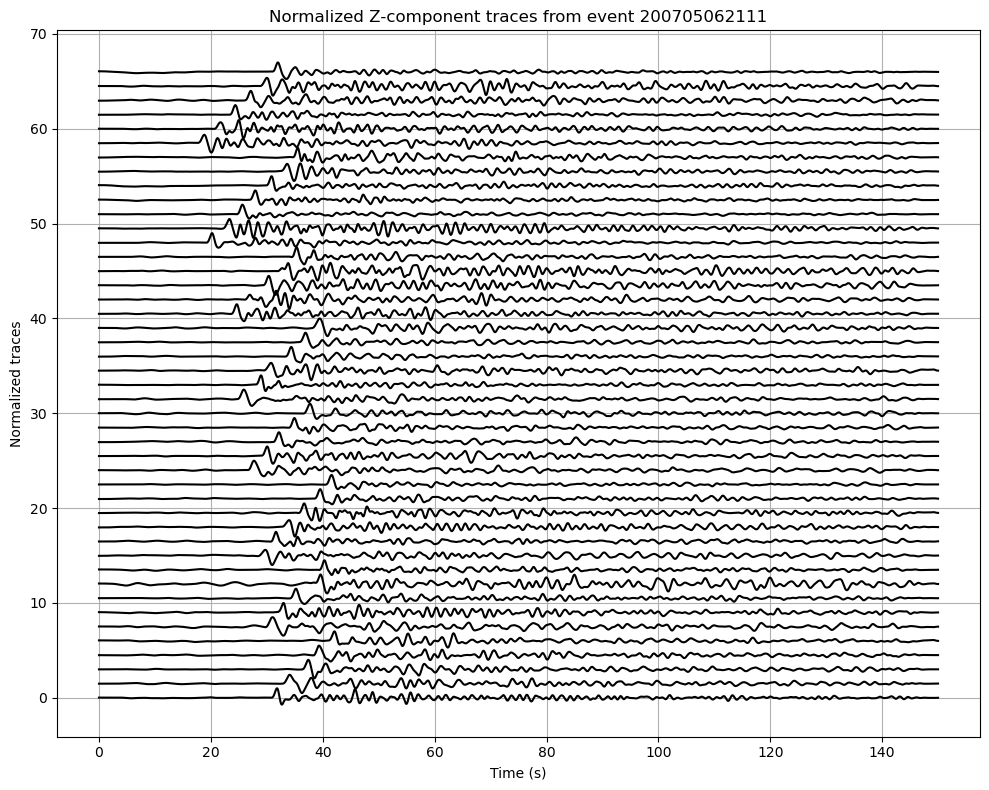

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from vespainv.utils import est_dom_freq, bandpass

# Load data
evname = "200705062111"
U_obs = np.loadtxt(os.path.join("./RealData/", evname, "UR.csv"), delimiter=",")
Utime = np.loadtxt(os.path.join("./RealData/", evname, "time.csv"), delimiter=",")

isbp = True
freqs = (0.02, 1.0)

if isbp:
    U_obs = bandpass(U_obs, 1/(Utime[1]-Utime[0]), freqs[0], freqs[1])

# Plot
plt.figure(figsize=(10, 8))
n_traces = U_obs.shape[1]
offset = 1.5  # vertical offset between traces

f0 = np.array([])

for i in range(n_traces):
    trace = U_obs[:, i]
    f0 = np.append(f0, est_dom_freq(trace, 1/(Utime[1]-Utime[0])))
    norm_trace = trace / np.max(np.abs(trace))
    plt.plot(Utime, norm_trace + i * offset, color='black')

print(f"Mean f₀: {np.mean(f0):.2f} Hz")
print(f"Median f₀: {np.median(f0):.2f} Hz")
print(f"Std dev of f₀: {np.std(f0):.2f} Hz")

plt.xlabel("Time (s)")
plt.ylabel("Normalized traces")
plt.title(f"Normalized Z-component traces from event {evname}")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
U_obs.ndim

2